In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [33]:
data = pd.read_csv('/content/drive/MyDrive/kaggle/Fetal_Health/dataset/fetal_health.csv')

In [34]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

###NAN caheck

In [36]:
#데이터프레임에서 결측치(NA값)의 총 개수를 계
data.isna().sum().sum()

0

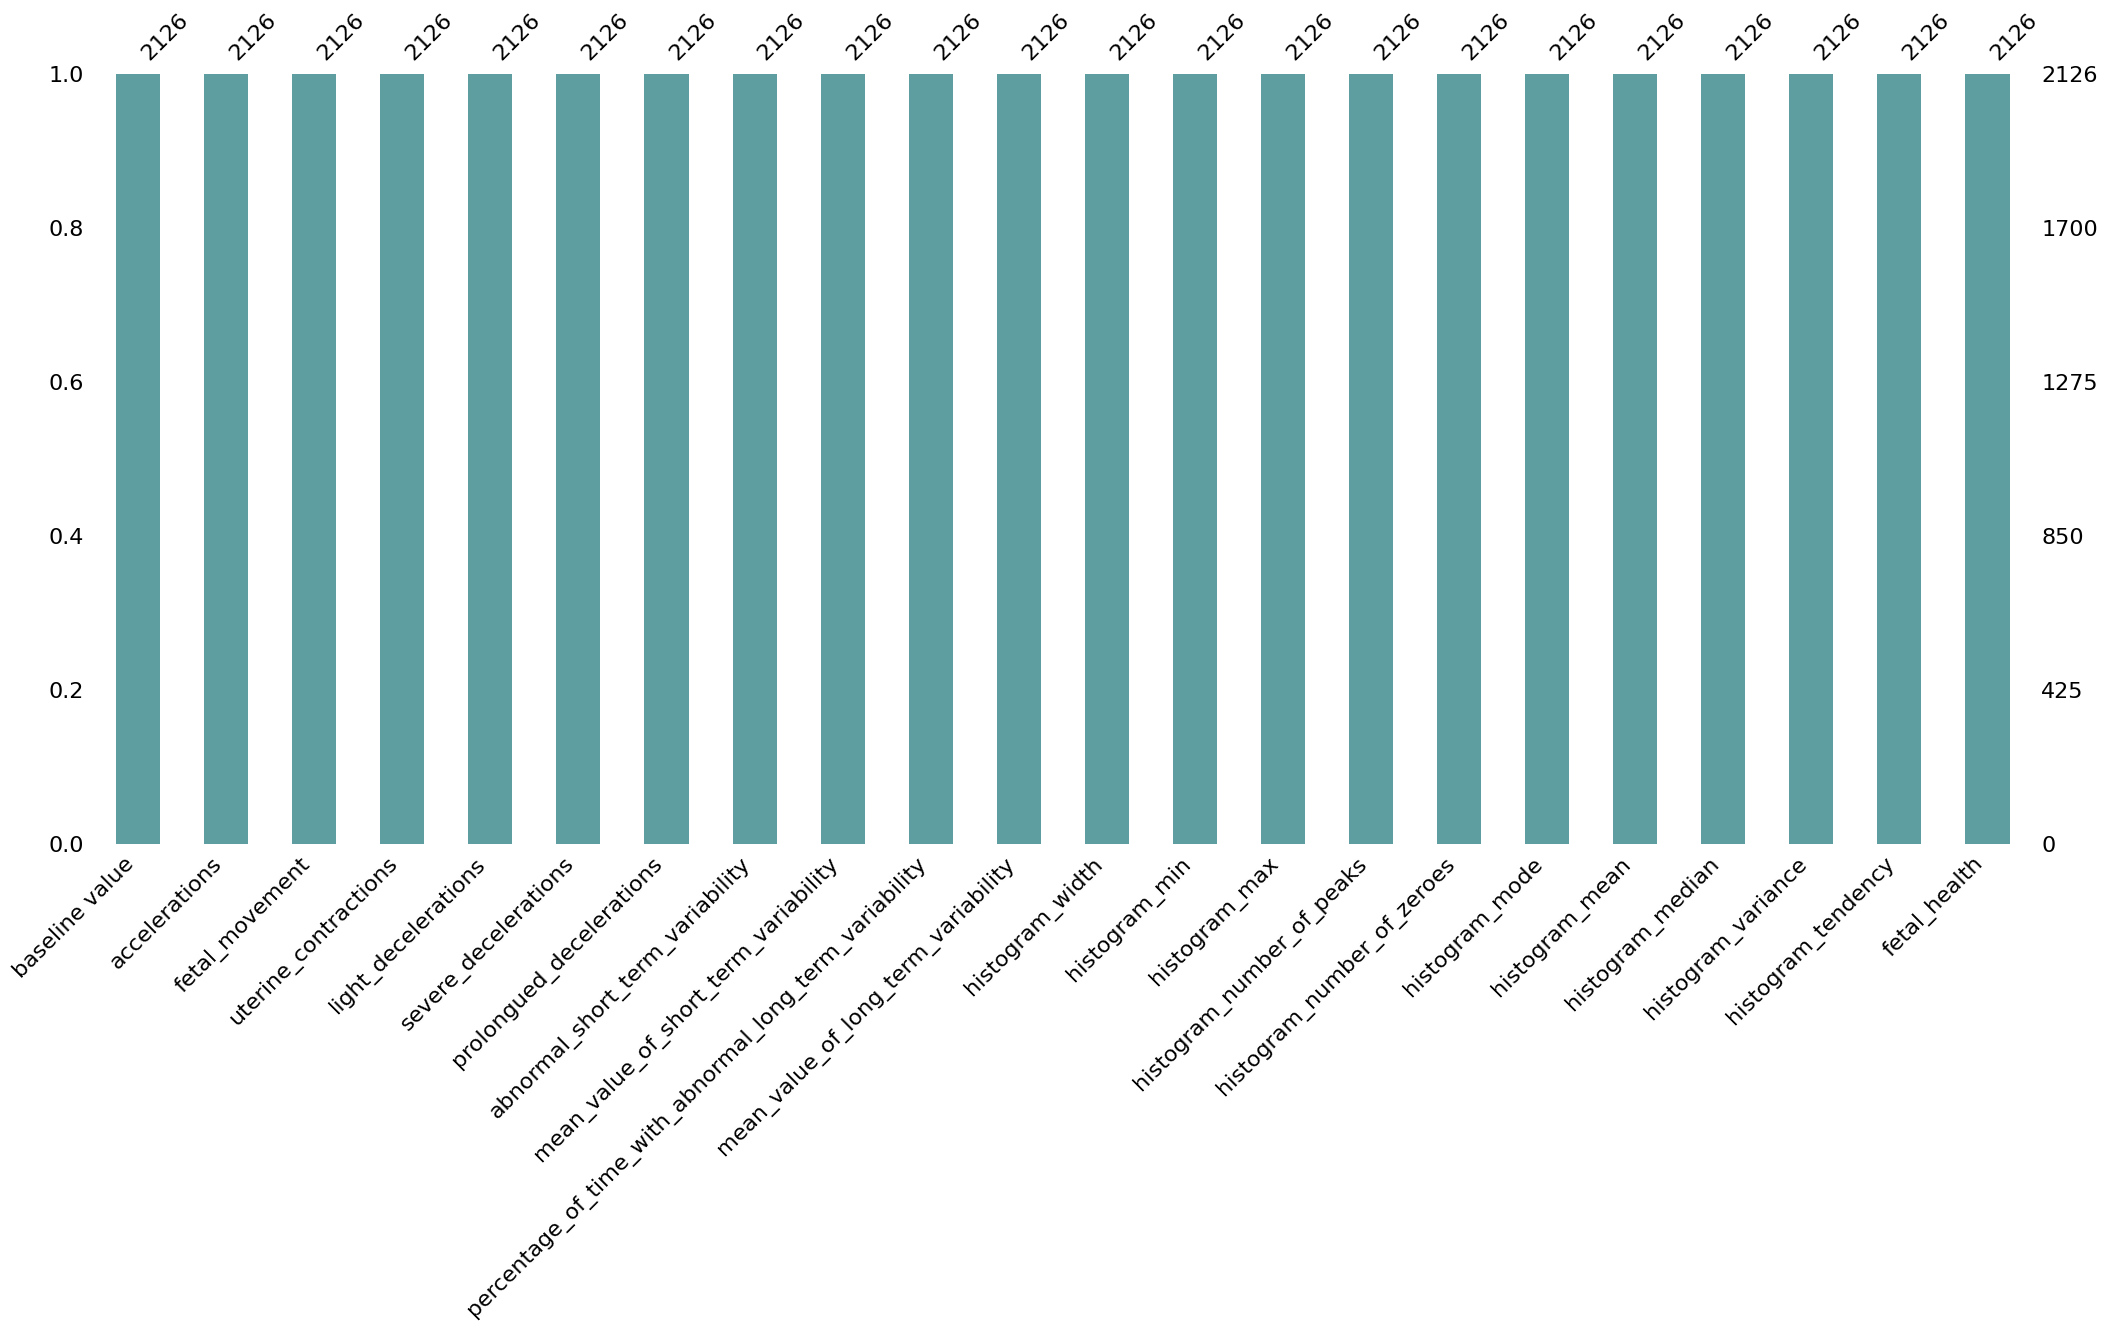

In [37]:
null_plot = msno.bar(data,color = '#5F9EA0')

###Exploratory Data Analysis

In [38]:
eda_df = data.copy()

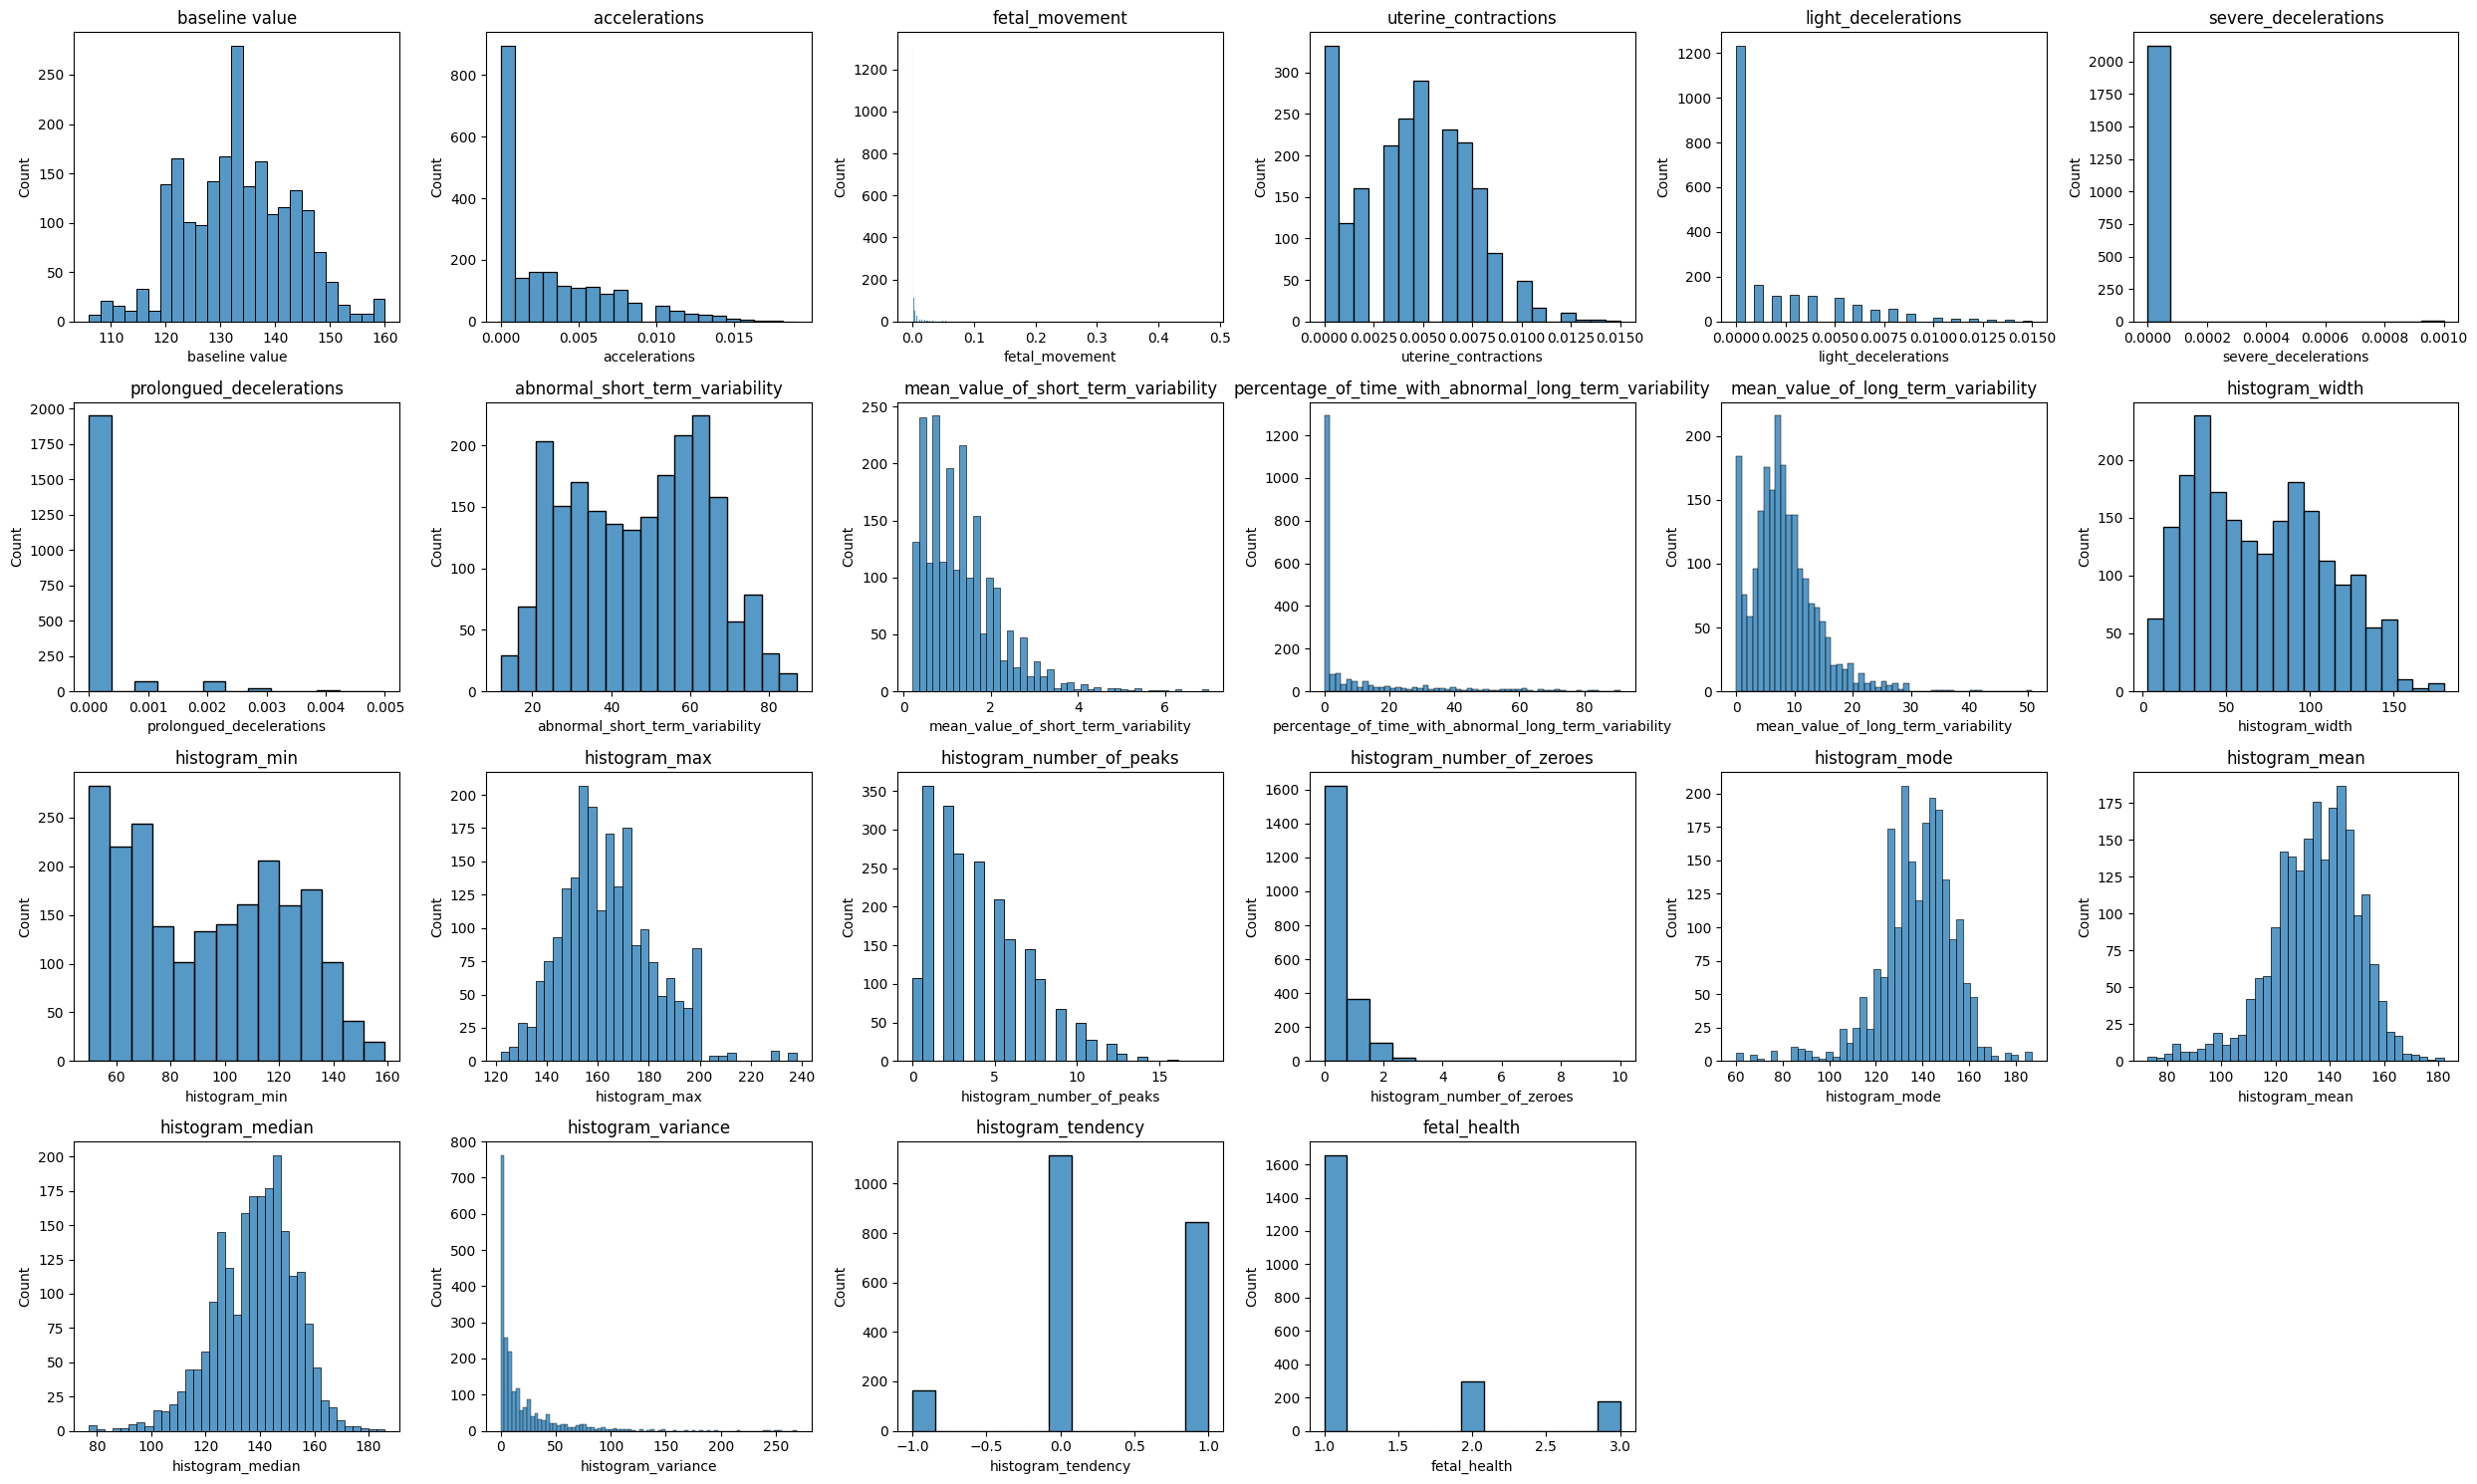

In [39]:
plt.figure(figsize=(25,15))

for i, column in enumerate(eda_df.columns) :
  plt.subplot(4, 6, i+1)
  sns.histplot(data=eda_df[column])
  plt.title(column)

plt.tight_layout()
plt.show()

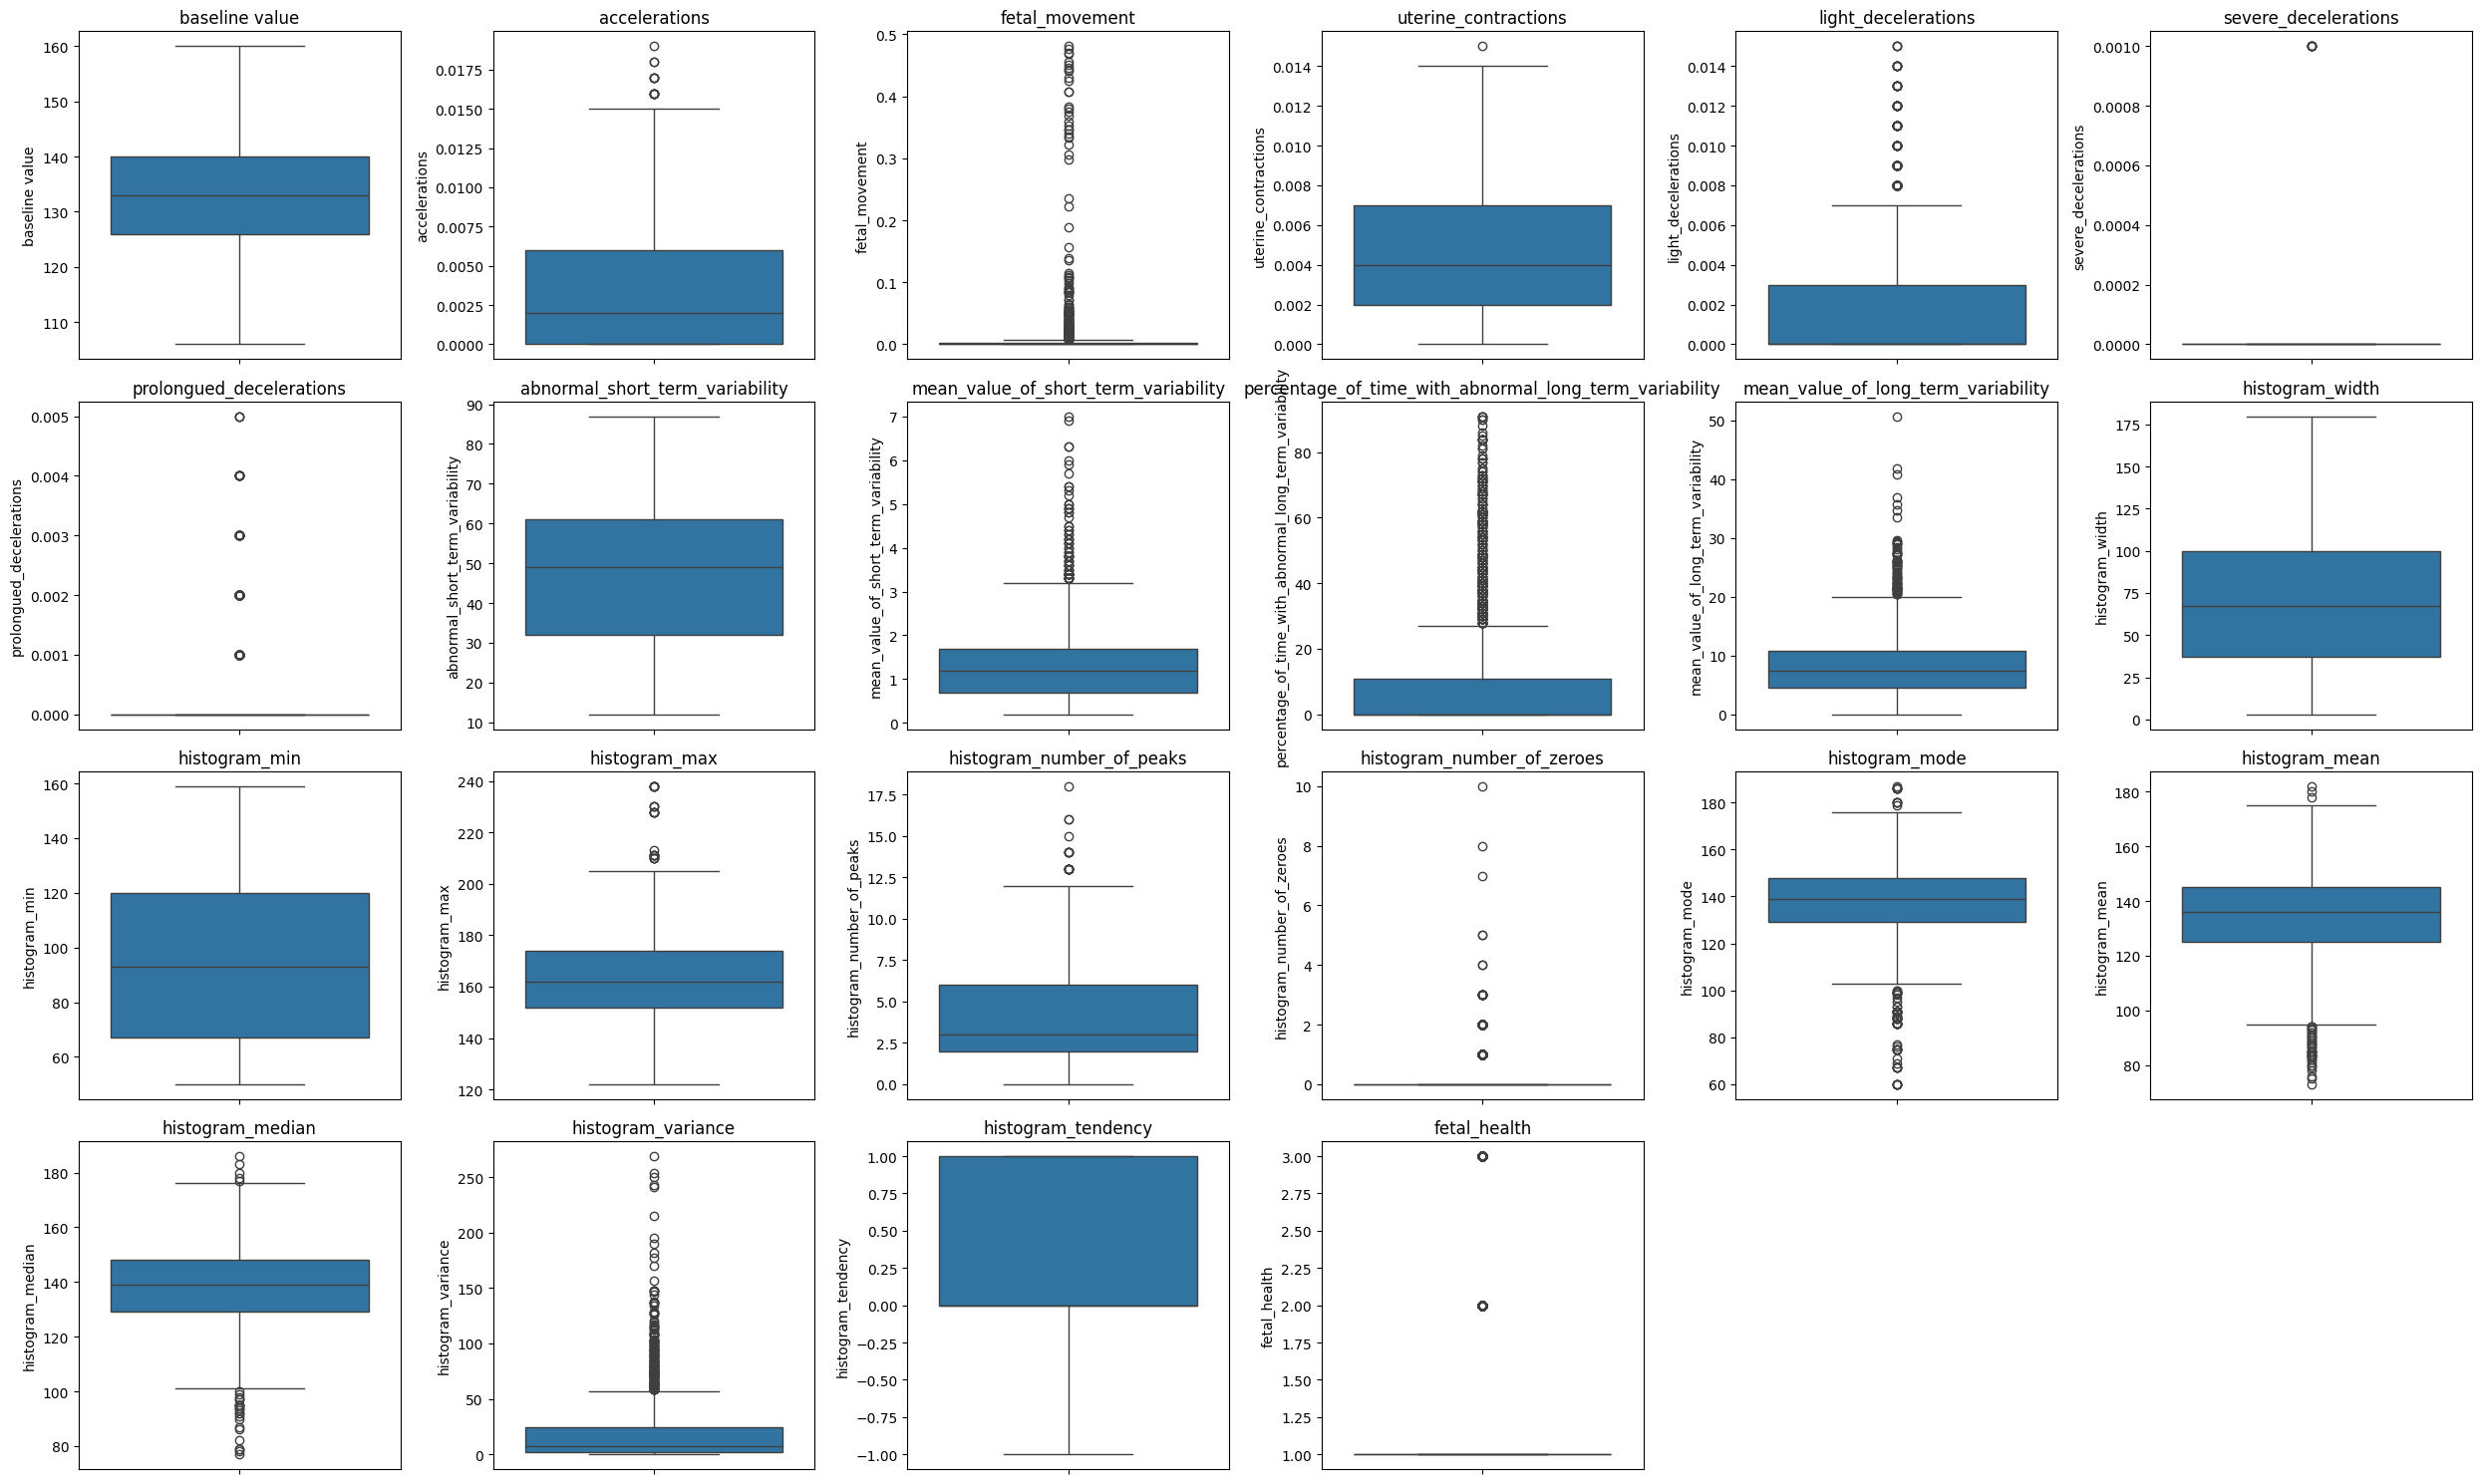

In [40]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(eda_df.columns) :
  plt.subplot(4, 6, i+1)
  sns.boxplot(data=eda_df[column])
  plt.title(column)

plt.tight_layout()
plt.show()

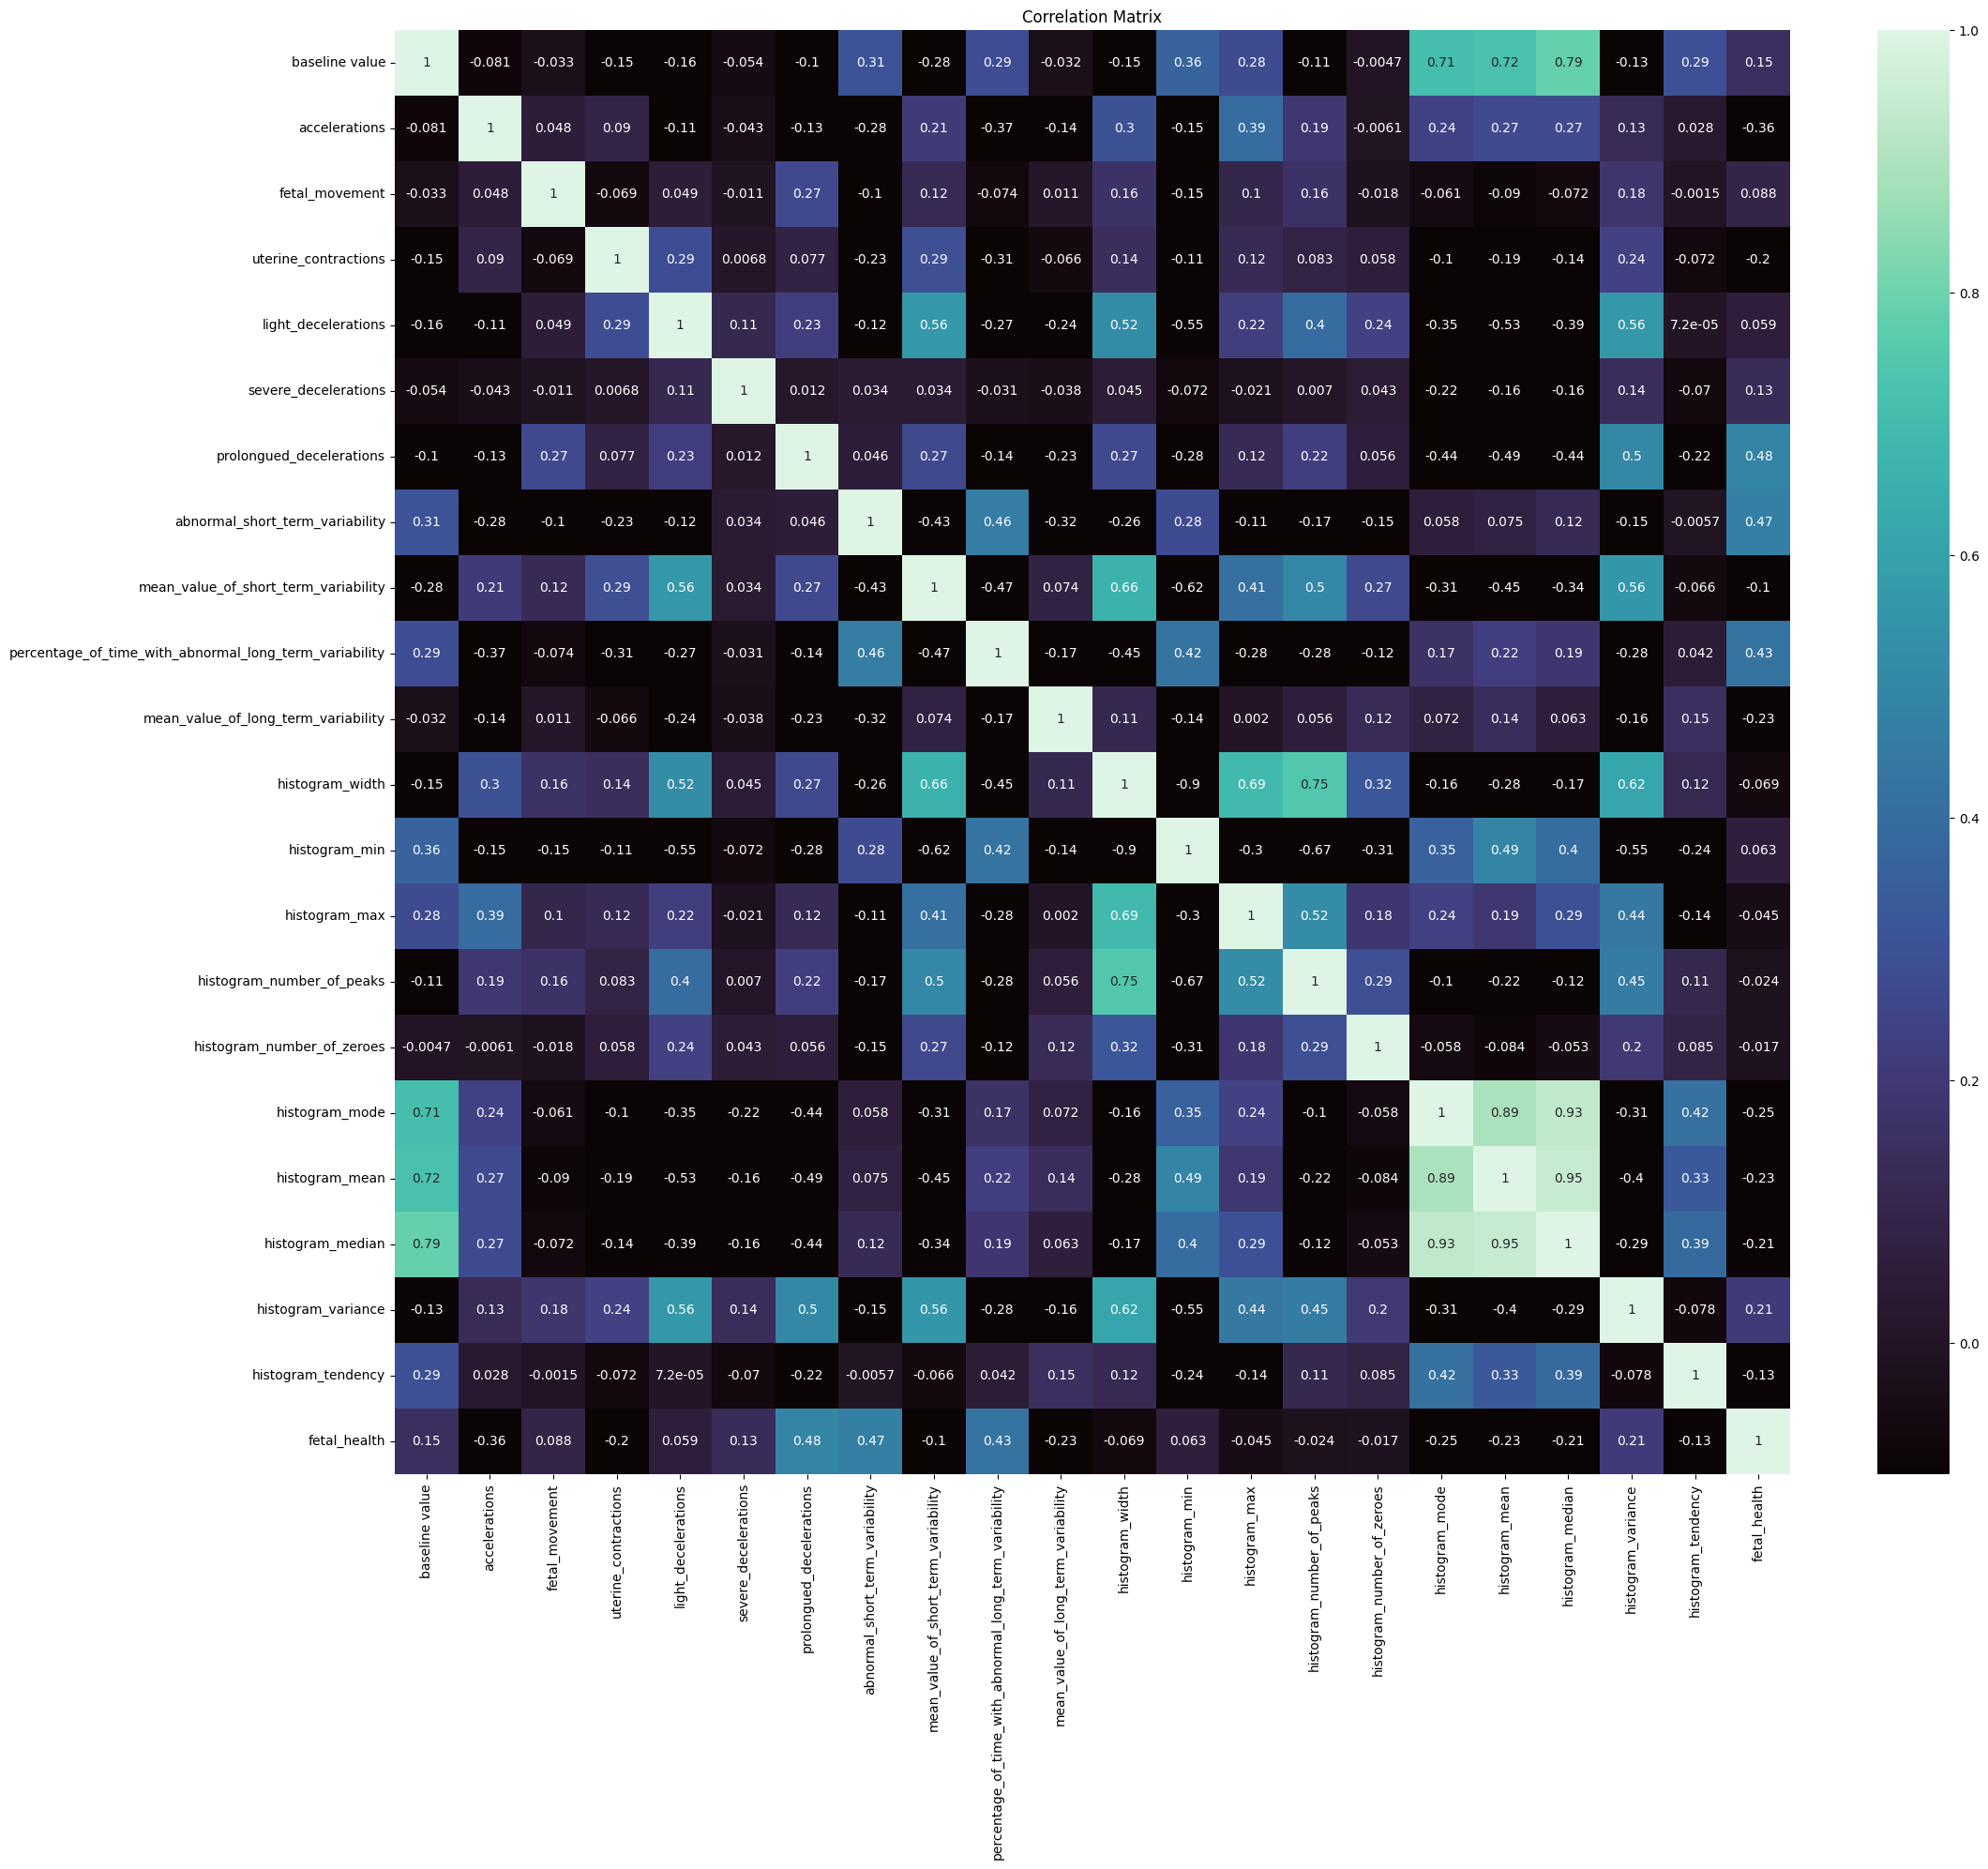

In [41]:
corr = eda_df.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, vmin=-0.1, cmap='mako')
plt.title("Correlation Matrix")
plt.show()

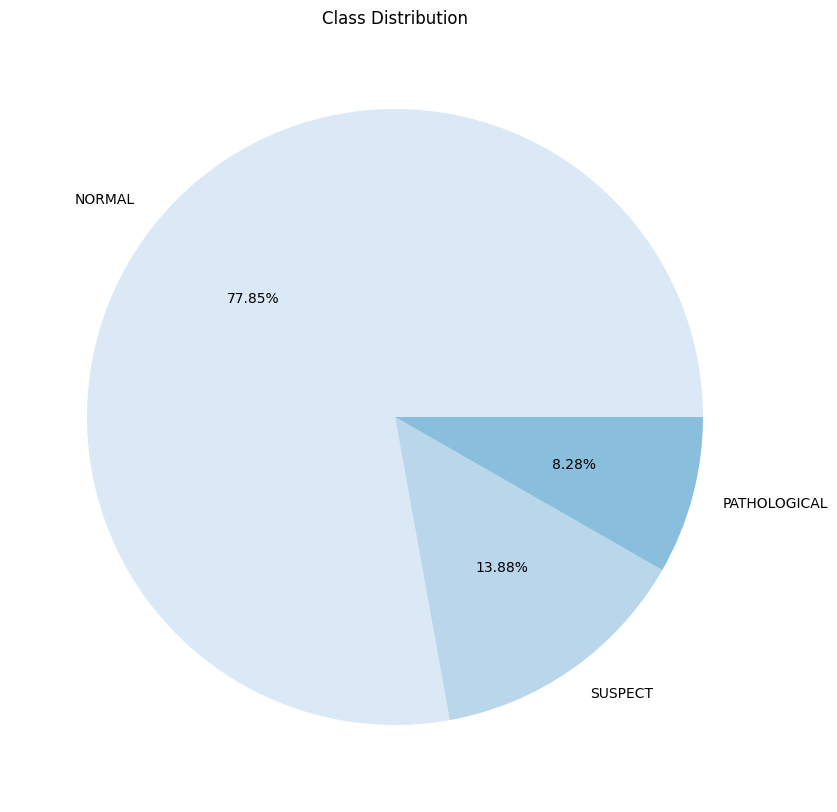

In [42]:
plt.figure(figsize=(10, 10))

plt.pie(
    eda_df['fetal_health'].value_counts(),
    autopct='%.2f%%',
    labels=["NORMAL", "SUSPECT", "PATHOLOGICAL"],
    colors=sns.color_palette('Blues')
)

plt.title("Class Distribution")
plt.show()

###Scaling the data / Preprocessing

In [43]:
#Split df into X and y
df = data.copy()
y = df['fetal_health']
X = df.drop('fetal_health', axis=1)

In [44]:
#OverSampling은 소수 클래스 데이터 포인트의 수를 증가시켜 클래스 간의 균형을 맞추는 방법 중 하나
#'not majority' 소수 클래스 수를 다수 클래스의 수와 같거나 그 이상으로 만들어 클래스 간의 균형 유지
oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(X,y)

In [45]:
#Scale X(표준화 작업) : 주어진 데이터의 각 특성을 평균이 0이고 표준편차가 1이 되도록 변
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_over)
X_scaled = pd.DataFrame(X_scaled,columns=X_over.columns)
X_scaled.shape

(4965, 21)

In [46]:
#PCA(주성분분석) -> 차원을 축소
#'n_components'매개변수는 주성부의 수 지정, 95%의 분산을 보존하도록 설정
pca=PCA(n_components=0.95)
X_pca_final=pca.fit_transform(X_scaled)
X_pca_final=pd.DataFrame(X_pca_final)
X_pca_final.shape

(4965, 13)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_final, y_over, shuffle=True, random_state=42, stratify = y_over)

In [48]:
#Cross Validation
cv_method = StratifiedKFold(n_splits=3,
                            random_state=None
                            )

#KNN Training

In [49]:
# params_knn = {"leaf_size": list(range(1,30)),
#               "n_neighbors": list(range(1,21)),
#               "p": [1,2]}
# GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(),
#                                 param_grid=params_knn,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_knn.fit(X_train, y_train)
# best_estimator_knn = GridSearchCV_knn.best_estimator_
# best_params_knn = GridSearchCV_knn.best_params_
# best_score_knn = GridSearchCV_knn.best_score_

In [50]:
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

<Axes: >

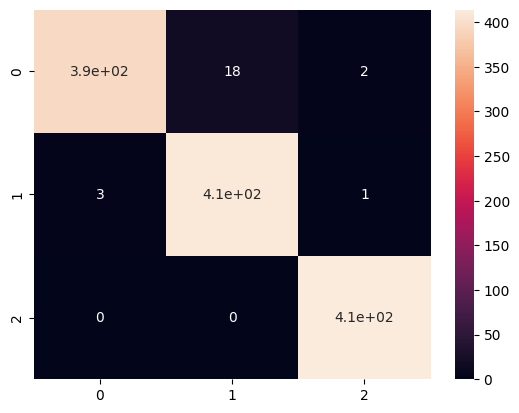

In [51]:
y_pred = knn.predict(X_test)
confusion_knn = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_knn,annot=True)

In [52]:
print(classification_report(y_test,knn.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97       414
         2.0       0.96      0.99      0.97       414
         3.0       0.99      1.00      1.00       414

    accuracy                           0.98      1242
   macro avg       0.98      0.98      0.98      1242
weighted avg       0.98      0.98      0.98      1242



<Axes: >

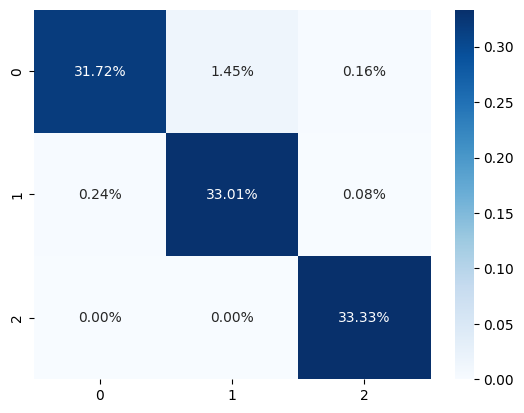

In [53]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

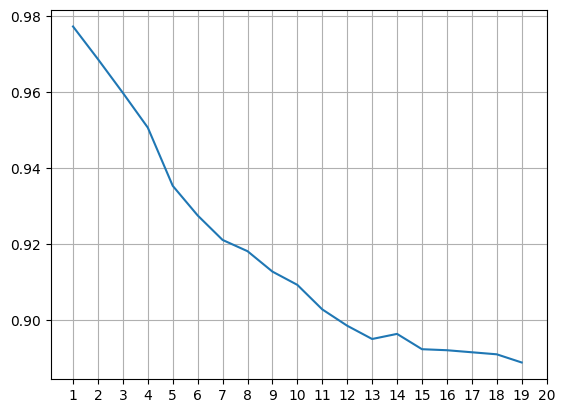

In [54]:
knn_scores=[]
for k in range(1,20) :
  knn1=KNeighborsClassifier(n_neighbors=k)
  scores=cross_val_score(knn1,X_train,y_train,cv=5)
  knn_scores.append(scores.mean())

x_ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
x_labels = x_ticks

plt.plot([k for k in range(1,20)], knn_scores)
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.grid()

###SVM Training

In [55]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [56]:
# param_grid={'C':[10,20,30,40,50,100], 'gamma':[10,100,110,120,130,150,200]}
# GridSearchCV_svm=GridSearchCV(SVC(),param_grid,cv=5)
# GridSearchCV_svm.fit(X_train,y_train)
# best_estimator_svm = GridSearchCV_svm.best_estimator_
# best_params_svm = GridSearchCV_svm.best_params_
# best_score_svm = GridSearchCV_svm.best_score_
# best_params_svm

In [57]:
svm=SVC(random_state=42, gamma = 100, C = 100)
svm.fit(X_train, y_train)
y_pred_svm=svm.predict(X_test)

<Axes: >

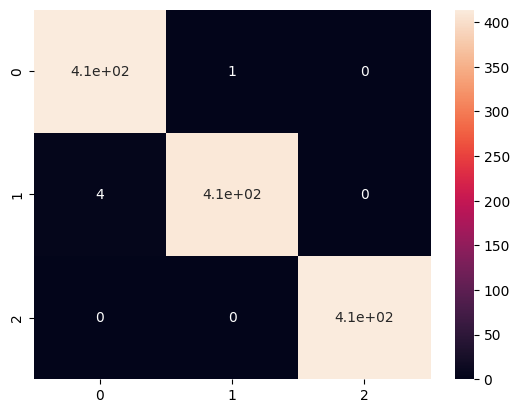

In [60]:
confusion_svm = confusion_matrix(y_test,svm.predict(X_test))
sns.heatmap(confusion_svm,annot=True)

In [61]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       414
         2.0       1.00      0.99      0.99       414
         3.0       1.00      1.00      1.00       414

    accuracy                           1.00      1242
   macro avg       1.00      1.00      1.00      1242
weighted avg       1.00      1.00      1.00      1242



<Axes: >

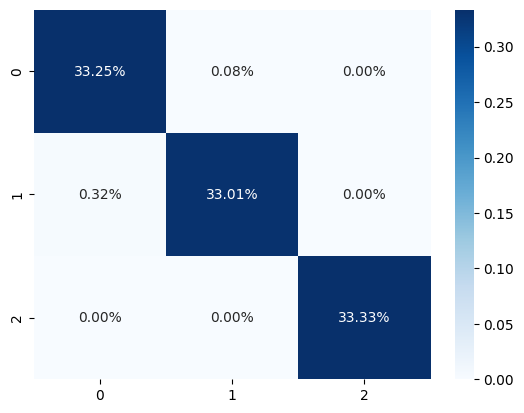

In [62]:
sns.heatmap(confusion_svm/np.sum(confusion_svm), annot=True, fmt='.2%', cmap='Blues')

###Decision Tree

In [63]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [64]:
# params_dt = {
#     "max_depth": list(range(1,20)),
#     "min_samples_leaf": list(range(1,30)),
#     "min_samples_split": list(range(1,40)),
#               }
# GridSearchCV_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
#                                 param_grid=params_dt,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_dt.fit(X_train, y_train)
# best_estimator_dt = GridSearchCV_dt.best_estimator_
# best_params_dt = GridSearchCV_dt.best_params_
# best_score_dt = GridSearchCV_dt.best_score_
# best_params_dt

In [67]:
dt=DecisionTreeClassifier(random_state=42,min_samples_leaf = 1, min_samples_split= 2, max_depth= 19)
dt.fit(X_train,y_train)
y_pred_dt=dt.predict(X_test)

<Axes: >

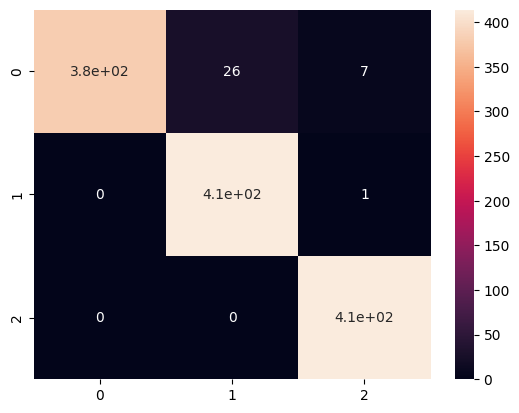

In [68]:
confusion_dt=confusion_matrix(y_test,dt.predict(X_test))
sns.heatmap(confusion_dt,annot=True)

In [69]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.92      0.96       414
         2.0       0.94      1.00      0.97       414
         3.0       0.98      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



###RF Tree

In [70]:
# param_grid = {
# 'n_estimators': [50, 100, 150, 200],
# }
# rf=RandomizedSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=5)
# rf.fit(X_train,y_train)
# y_pred_rf=rf.predict(X_test)
# rf.best_params_

In [71]:
rf = RandomForestClassifier(random_state=42, min_samples_leaf = 1, min_samples_split=2, max_depth=19)
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

<Axes: >

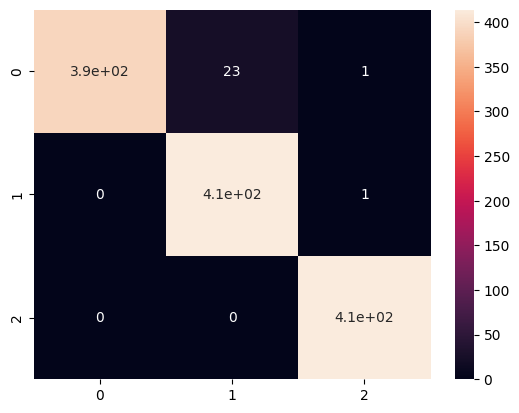

In [73]:
confusion_rf = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(confusion_rf,annot=True)

In [74]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97       414
         2.0       0.95      1.00      0.97       414
         3.0       1.00      1.00      1.00       414

    accuracy                           0.98      1242
   macro avg       0.98      0.98      0.98      1242
weighted avg       0.98      0.98      0.98      1242



###Gradient Boost

In [75]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [76]:
# params_gb = {
#     "learning_rate": [0.01,0.1,1,10],
#     'n_estimators': [50, 100, 150, 200],
# #     "max_depth": list(range(1,20)),
# #     "min_samples_leaf": list(range(1,10)),
# #     "min_samples_split": list(range(1,10)),
#               }
# GridSearchCV_gb = GridSearchCV(estimator=GradientBoostingClassifier(),
#                                 param_grid=params_gb,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_gb.fit(X_train, y_train)
# best_estimator_gb = GridSearchCV_gb.best_estimator_
# best_params_gb = GridSearchCV_gb.best_params_
# best_score_gb = GridSearchCV_gb.best_score_
# best_params_gb

In [77]:
gb=GradientBoostingClassifier(random_state=42, learning_rate=1.0, n_estimators=50, subsample = 0.8, min_samples_leaf =1, min_samples_split=2, max_depth=19)
gb.fit(X_train,y_train)
y_pred_gb=gb.predict(X_test)

<Axes: >

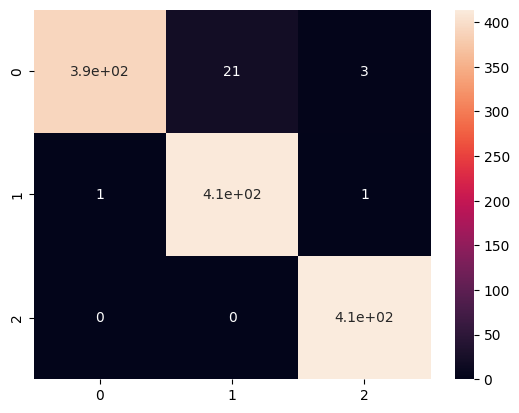

In [78]:
confusion_gb=confusion_matrix(y_test,gb.predict(X_test))
sns.heatmap(confusion_gb, annot=True)

In [79]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.92      0.96       414
         2.0       0.94      1.00      0.97       414
         3.0       0.98      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



In [86]:
print(f"Accuracy of KNN model -> {round(knn.score(X_test, y_test),4)*100}%")
print(f"Accuracy of SVM model -> {round(svm.score(X_test, y_test),3)*100}%")
print(f"Accuracy of RF model -> {round(rf.score(X_test, y_test),4)*100}%")
print(f"Accuracy of DT model -> {round(dt.score(X_test, y_test),4)*100}%")
print(f"Accuracy of GB model -> {round(gb.score(X_test, y_test),3)*100}%")

Accuracy of KNN model -> 98.07000000000001%
Accuracy of SVM model -> 99.6%
Accuracy of RF model -> 97.99%
Accuracy of DT model -> 97.26%
Accuracy of GB model -> 97.89999999999999%
